使用最优匹配研究形状对测试准确度的影响

PRNU库的建立

Testing PENTAX K20D: 100%|██████████| 5/5 [00:45<00:00,  9.12s/it]


Overall accuracy on the test set: 100.00%
Visualizing PRNU fingerprints for all cameras:


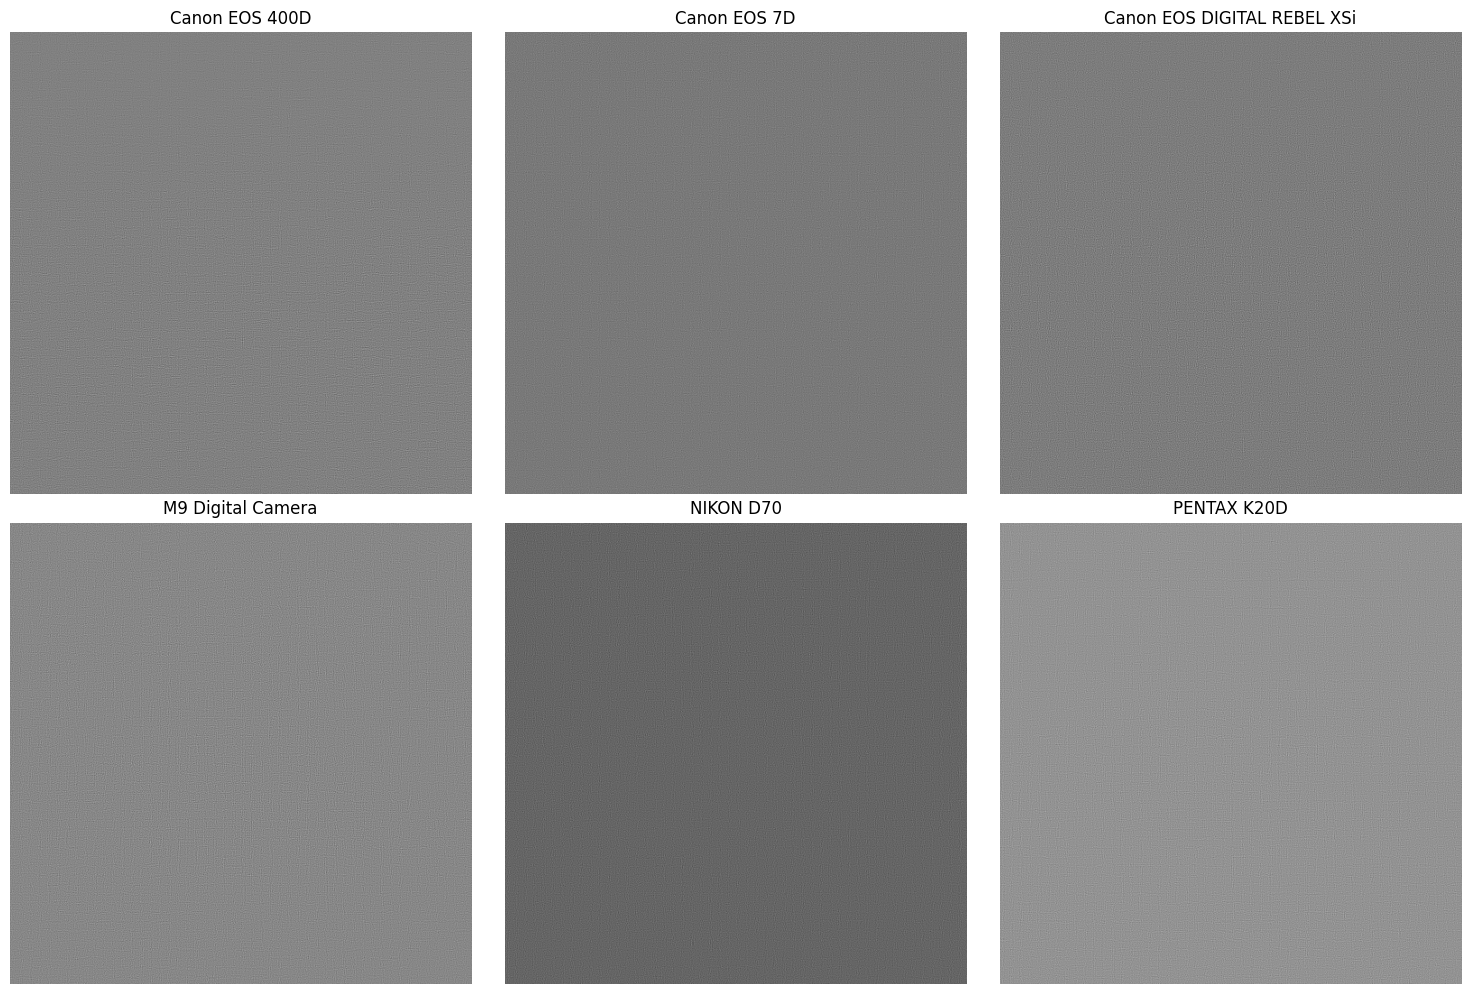

In [13]:
import cv2
import numpy as np
import pywt
import rawpy
from scipy.stats import pearsonr
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

def read_raw_image(image_path):
    # 读取图像并转换为灰度图像
    with rawpy.imread(image_path) as raw:
        rgb = raw.postprocess()
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
        return gray

def preprocess_image(image_path, target_size=(2048, 2048)):
    img = read_raw_image(image_path)
    h, w = img.shape
    # 去除图像边缘部分
    cropped_img = img[10:h-10, 10:w-10]
    resized_img = cv2.resize(cropped_img, target_size, interpolation=cv2.INTER_AREA)
    return resized_img

def wavelet_denoise(image):
    # 小波变换，使用 'db2' 小波和2级分解
    coeffs = pywt.wavedec2(image, 'db2', level=2)
    # 对高频系数进行阈值处理
    cA2, (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs
    cH1 = pywt.threshold(cH1, np.std(cH1)/2, mode='soft')
    cV1 = pywt.threshold(cV1, np.std(cV1)/2, mode='soft')
    cD1 = pywt.threshold(cD1, np.std(cD1)/2, mode='soft')
    cH2 = pywt.threshold(cH2, np.std(cH2)/2, mode='soft')
    cV2 = pywt.threshold(cV2, np.std(cV2)/2, mode='soft')
    cD2 = pywt.threshold(cD2, np.std(cD2)/2, mode='soft')
    # 重构图像
    denoised_image = pywt.waverec2((cA2, (cH2, cV2, cD2), (cH1, cV1, cD1)), 'db2')
    return denoised_image

def calculate_noise_residual(image, denoised_image):
    # 计算噪声残差
    noise_residual = image - denoised_image
    return noise_residual

def extract_prnu(images, target_size=(2048, 2048)):
    # 提取多张图像的噪声残差
    noise_residuals = []
    for img in tqdm(images, desc="Extracting PRNU"):
        preprocessed_img = preprocess_image(img, target_size)
        denoised_img = wavelet_denoise(preprocessed_img)
        noise_residual = calculate_noise_residual(preprocessed_img, denoised_img)
        noise_residuals.append(noise_residual)
    # 计算平均噪声残差（PRNU指纹）
    avg_noise_residual = np.mean(noise_residuals, axis=0)
    # 对平均噪声残差进行标准化
    prnu_fingerprint = (avg_noise_residual - np.mean(avg_noise_residual)) / np.std(avg_noise_residual)
    return prnu_fingerprint

def build_prnu_library(image_folder, target_size=(2048, 2048), test_ratio=0.05):
    # 遍历图像文件夹，提取PRNU指纹
    prnu_library = {}
    test_images = {}
    for root, _, files in os.walk(image_folder):
        image_files = [file for file in files if file.lower().endswith(('.cr2', '.dng', '.nef', '.pef'))]
        random.shuffle(image_files)
        split_index = int(len(image_files) * (1 - test_ratio))
        train_files = image_files[:split_index]
        test_files = image_files[split_index:]
        if train_files:
            camera_id = os.path.basename(root)
            prnu_library[camera_id] = extract_prnu([os.path.join(root, f) for f in train_files], target_size)
            test_images[camera_id] = [os.path.join(root, f) for f in test_files]
    return prnu_library, test_images

def correlate_prnu(test_image, prnu_fingerprint, target_size=(2048, 2048)):
    # 预处理测试图像
    preprocessed_img = preprocess_image(test_image)
    # 去噪测试图像
    denoised_img = wavelet_denoise(preprocessed_img)
    # 计算测试图像的噪声残差
    noise_residual = calculate_noise_residual(preprocessed_img, denoised_img)
    # 计算噪声残差的标准化
    normalized_noise_residual = (noise_residual - np.mean(noise_residual)) / np.std(noise_residual)
    # 计算皮尔逊相关系数
    correlation, _ = pearsonr(normalized_noise_residual.flatten(), prnu_fingerprint.flatten())
    return correlation

def match_camera(test_image, prnu_library, target_size=(2048, 2048)):
    # 对测试图像进行PRNU指纹匹配
    best_match = None
    highest_correlation = -1
    for camera_id, prnu_fingerprint in prnu_library.items():
        correlation = correlate_prnu(test_image, prnu_fingerprint, target_size)
        if correlation > highest_correlation:
            highest_correlation = correlation
            best_match = camera_id
    return best_match, highest_correlation

def evaluate_accuracy(prnu_library, test_images, target_size=(2048, 2048)):
    #计算评估测试准确度
    correct_matches = 0
    total_tests = 0
    accuracy_results = {}
    for camera_id, images in test_images.items():
        correct = 0
        for img in tqdm(images, desc=f"Testing {camera_id}"):
            matched_camera, correlation = match_camera(img, prnu_library, target_size)
            total_tests += 1
            if matched_camera == camera_id:
                correct += 1
                correct_matches += 1
        accuracy = correct / len(images) if images else 0
        accuracy_results[camera_id] = accuracy
    overall_accuracy = correct_matches / total_tests if total_tests > 0 else 0
    return overall_accuracy, accuracy_results

def visualize_prnu(prnu_library):
    #可视化PRNU指纹
    num_cameras = len(prnu_library)
    if num_cameras == 0:
        print("No cameras found in PRNU library.")
        return
    rows = 2
    cols = 3
    fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
    axs = axs.flatten()
    for idx, (camera_id, prnu_fingerprint) in enumerate(prnu_library.items()):
        ax = axs[idx]
        ax.imshow(prnu_fingerprint, cmap='gray')
        ax.set_title(camera_id)
        ax.axis('off')
    for ax in axs[len(prnu_library):]:
        fig.delaxes(ax)
    plt.tight_layout()
    plt.show()


def evaluate_different_sizes(image_folder, sizes, test_ratio=0.05):
    #计算不同形状下的测试准确度
    accuracies = []
    for size in sizes:
        print(f"Evaluating for target size: {size}")
        target_size = (size, size)
        prnu_library, test_images = build_prnu_library(image_folder, target_size, test_ratio)
        accuracy, _ = evaluate_accuracy(prnu_library, test_images, target_size)
        accuracies.append(accuracy)
    plt.plot(sizes, accuracies, marker='o')
    plt.xlabel("Image Size")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Image Size")
    plt.show()

if __name__ == "__main__":
    image_folder = "BossBase-1.0-raw01"
    target_size = (2048, 2048)
    test_ratio = 0.05

    prnu_library, test_images = build_prnu_library(image_folder, target_size, test_ratio)

    overall_accuracy, accuracy_results = evaluate_accuracy(prnu_library, test_images, target_size)
    print(f"Overall accuracy on the test set: {overall_accuracy * 100:.2f}%")

    print("Visualizing PRNU fingerprints for all cameras:")
    visualize_prnu(prnu_library)


可视化不同相机的测试准确度

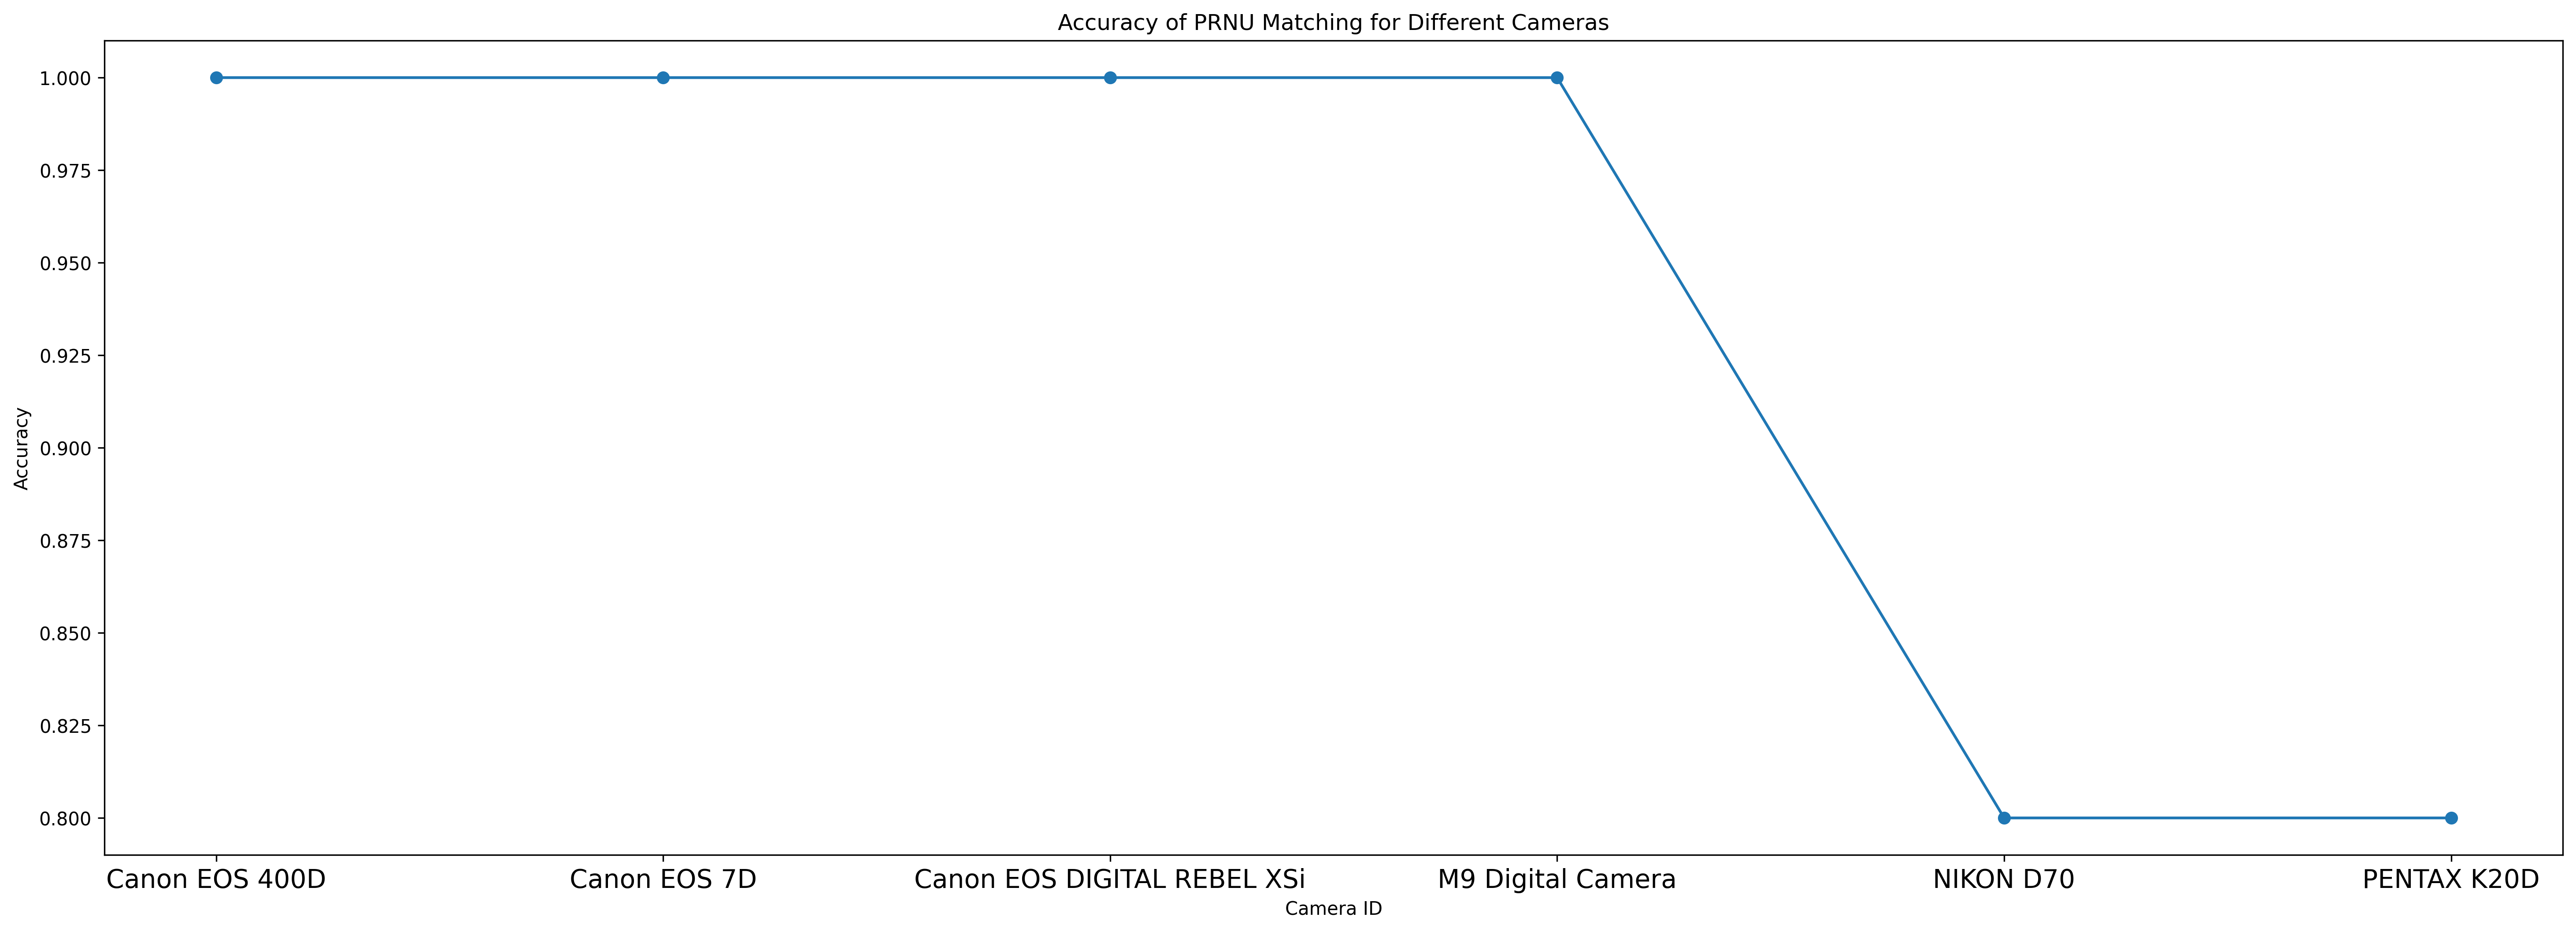

In [12]:
def plot_accuracy(accuracy_results):
    cameras = list(accuracy_results.keys())
    accuracies = list(accuracy_results.values())
    plt.figure(dpi=300,figsize=(24,8))
    plt.plot(cameras, accuracies, marker='o')
    plt.xticks(fontsize=14)
    plt.xlabel("Camera ID")
    plt.ylabel("Accuracy")
    plt.title("Accuracy of PRNU Matching for Different Cameras")
    plt.show()
    
plot_accuracy(accuracy_results)

计算不同形状下的测试准确度并可视化

Evaluating for target size: 128


Testing PENTAX K20D: 100%|██████████| 5/5 [00:29<00:00,  5.99s/it]


Evaluating for target size: 256


Testing PENTAX K20D: 100%|██████████| 5/5 [00:30<00:00,  6.07s/it]


Evaluating for target size: 512


Testing PENTAX K20D: 100%|██████████| 5/5 [00:28<00:00,  5.70s/it]


Evaluating for target size: 1024


Testing PENTAX K20D: 100%|██████████| 5/5 [00:31<00:00,  6.23s/it]


Evaluating for target size: 2048


Testing PENTAX K20D: 100%|██████████| 5/5 [00:45<00:00,  9.02s/it]


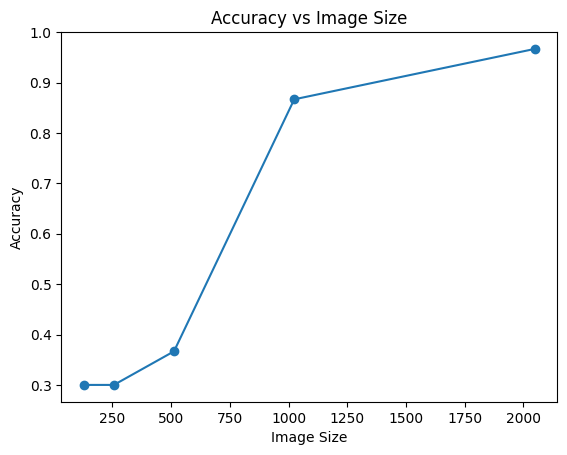

In [3]:
sizes = [128, 256, 512, 1024, 2048]
evaluate_different_sizes(image_folder, sizes, test_ratio=0.05)

使用阈值判断数字图像源

PRNU库的建立

In [28]:
import cv2
import numpy as np
import pywt
import rawpy
from scipy.stats import pearsonr
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

def read_raw_image(image_path):
    with rawpy.imread(image_path) as raw:
        rgb = raw.postprocess()
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
        return gray

def preprocess_image(image_path, target_size=(2048, 2048)):
    img = read_raw_image(image_path)
    h, w = img.shape
    cropped_img = img[10:h-10, 10:w-10]
    resized_img = cv2.resize(cropped_img, target_size, interpolation=cv2.INTER_AREA)
    return resized_img

def wavelet_denoise(image):
    coeffs = pywt.wavedec2(image, 'db2', level=2)
    cA2, (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs
    cH1 = pywt.threshold(cH1, np.std(cH1)/2, mode='soft')
    cV1 = pywt.threshold(cV1, np.std(cV1)/2, mode='soft')
    cD1 = pywt.threshold(cD1, np.std(cD1)/2, mode='soft')
    cH2 = pywt.threshold(cH2, np.std(cH2)/2, mode='soft')
    cV2 = pywt.threshold(cV2, np.std(cV2)/2, mode='soft')
    cD2 = pywt.threshold(cD2, np.std(cD2)/2, mode='soft')
    denoised_image = pywt.waverec2((cA2, (cH2, cV2, cD2), (cH1, cV1, cD1)), 'db2')
    return denoised_image

def calculate_noise_residual(image, denoised_image):
    noise_residual = image - denoised_image
    return noise_residual

def extract_prnu(images, target_size=(2048, 2048)):
    noise_residuals = []
    for img in tqdm(images, desc="Extracting PRNU"):
        preprocessed_img = preprocess_image(img, target_size)
        denoised_img = wavelet_denoise(preprocessed_img)
        noise_residual = calculate_noise_residual(preprocessed_img, denoised_img)
        noise_residuals.append(noise_residual)
    avg_noise_residual = np.mean(noise_residuals, axis=0)
    prnu_fingerprint = (avg_noise_residual - np.mean(avg_noise_residual)) / np.std(avg_noise_residual)
    return prnu_fingerprint

def build_prnu_library(image_folder, target_size=(2048, 2048), test_ratio=0.05):
    prnu_library = {}
    train_images = {}
    test_images = {}
    camera_folders = ["Canon EOS 7D", "Canon EOS 400D", "Canon EOS DIGITAL REBEL XSi", "M9 Digital Camera", "NIKON D70", "PENTAX K20D"]
    for i, camera_folder in enumerate(camera_folders):
        folder_path = os.path.join(image_folder, camera_folder)
        image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith(('.cr2', '.dng', '.nef', '.pef'))]
        random.shuffle(image_files)
        split_index = int(len(image_files) * (1 - test_ratio))
        if i < 5:
            train_files = image_files[:split_index]
            test_files = image_files[split_index:]
            if train_files:
                prnu_library[camera_folder] = extract_prnu(train_files, target_size)
                train_images[camera_folder] = train_files
            if test_files:
                if camera_folder in test_images:
                    test_images[camera_folder].extend(test_files)
                else:
                    test_images[camera_folder] = test_files
        else:
            test_files = image_files[:int(len(image_files) * test_ratio)]
            if test_files:
                if camera_folder in test_images:
                    test_images["None"].extend(test_files)
                else:
                    test_images["None"] = test_files
    return prnu_library, train_images, test_images

if __name__ == "__main__":
    image_folder = "BossBase-1.0-raw01"
    target_size = (2048, 2048)
    test_ratio = 0.05

    prnu_library, train_images, test_images = build_prnu_library(image_folder, target_size, test_ratio)

    print("Training images used for each camera:")
    for camera_id, images in train_images.items():
        print(f"{camera_id}: {len(images)} images")

    print("Testing images used for each camera:")
    for camera_id, images in test_images.items():
        print(f"{camera_id}: {len(images)} images")

Extracting PRNU:   0%|          | 0/95 [00:00<?, ?it/s]

Extracting PRNU: 100%|██████████| 95/95 [01:40<00:00,  1.06s/it]


Training images used for each camera:
Canon EOS 7D: 95 images
Canon EOS 400D: 95 images
Canon EOS DIGITAL REBEL XSi: 95 images
M9 Digital Camera: 95 images
NIKON D70: 95 images
Testing images used for each camera:
Canon EOS 7D: 5 images
Canon EOS 400D: 5 images
Canon EOS DIGITAL REBEL XSi: 5 images
M9 Digital Camera: 5 images
NIKON D70: 5 images
None: 5 images


计算各个相机的阈值，并进行测试

Calculating threshold for Canon EOS 400D: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]
Calculating threshold for Canon EOS DIGITAL REBEL XSi: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]
Calculating threshold for NIKON D70: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Calculated correlation thresholds: {'Canon EOS 7D': 0.016021234952207298, 'Canon EOS 400D': 0.006969683364794348, 'Canon EOS DIGITAL REBEL XSi': 0.006920206419938928, 'M9 Digital Camera': 0.005028384256867687, 'NIKON D70': 0.004904357139861901}


Testing None: 100%|██████████| 5/5 [00:37<00:00,  7.52s/it]


Overall accuracy on the test set: 93.33%


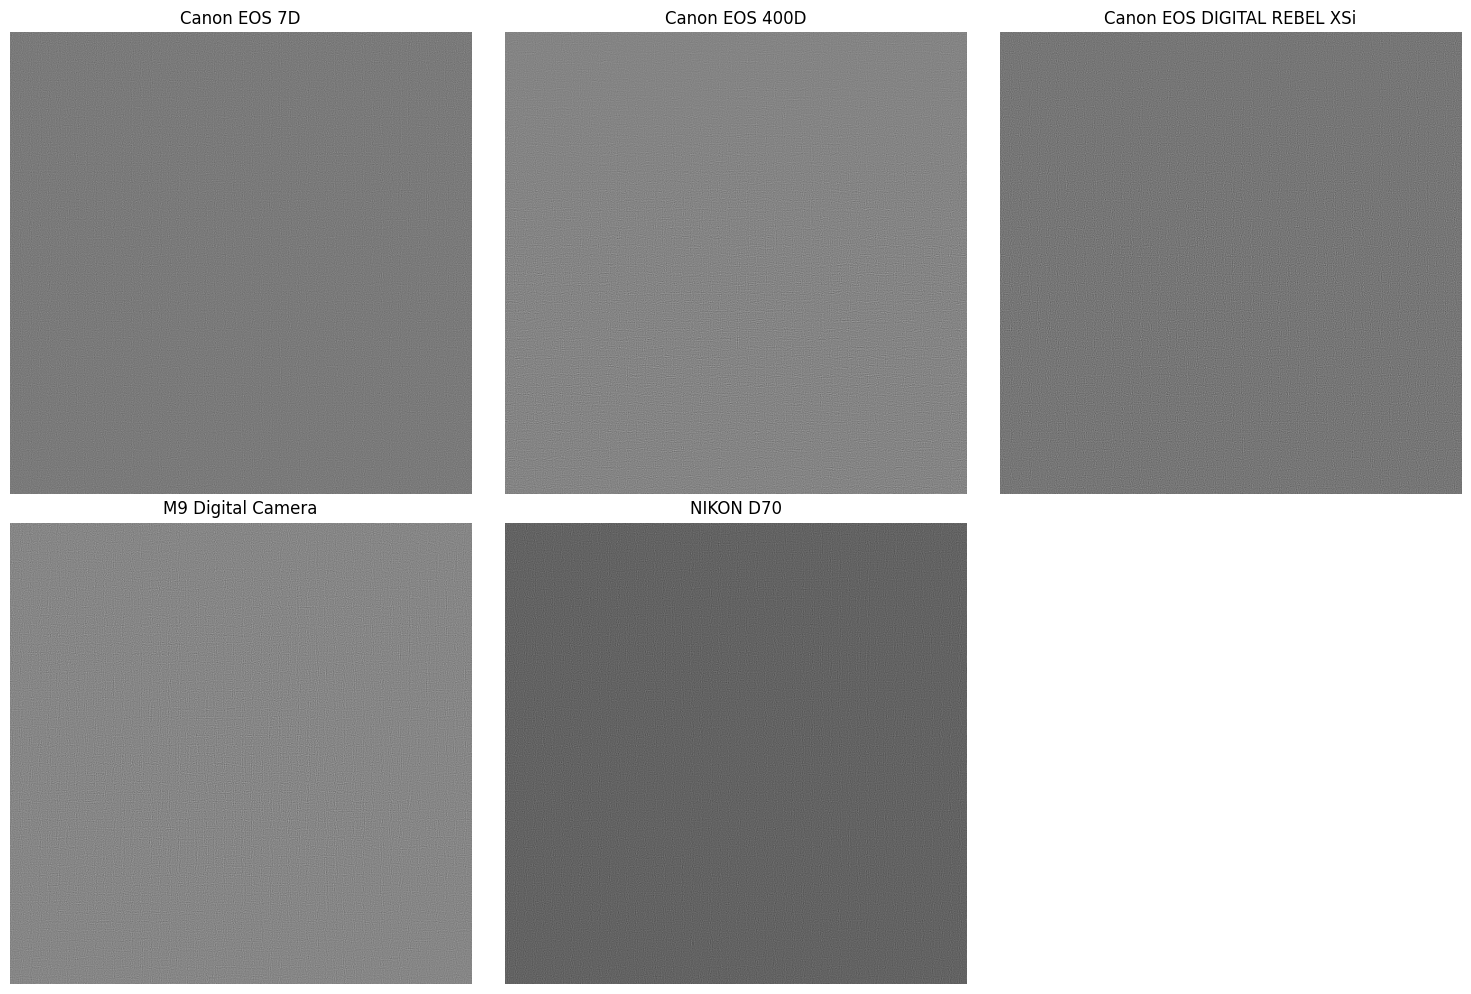

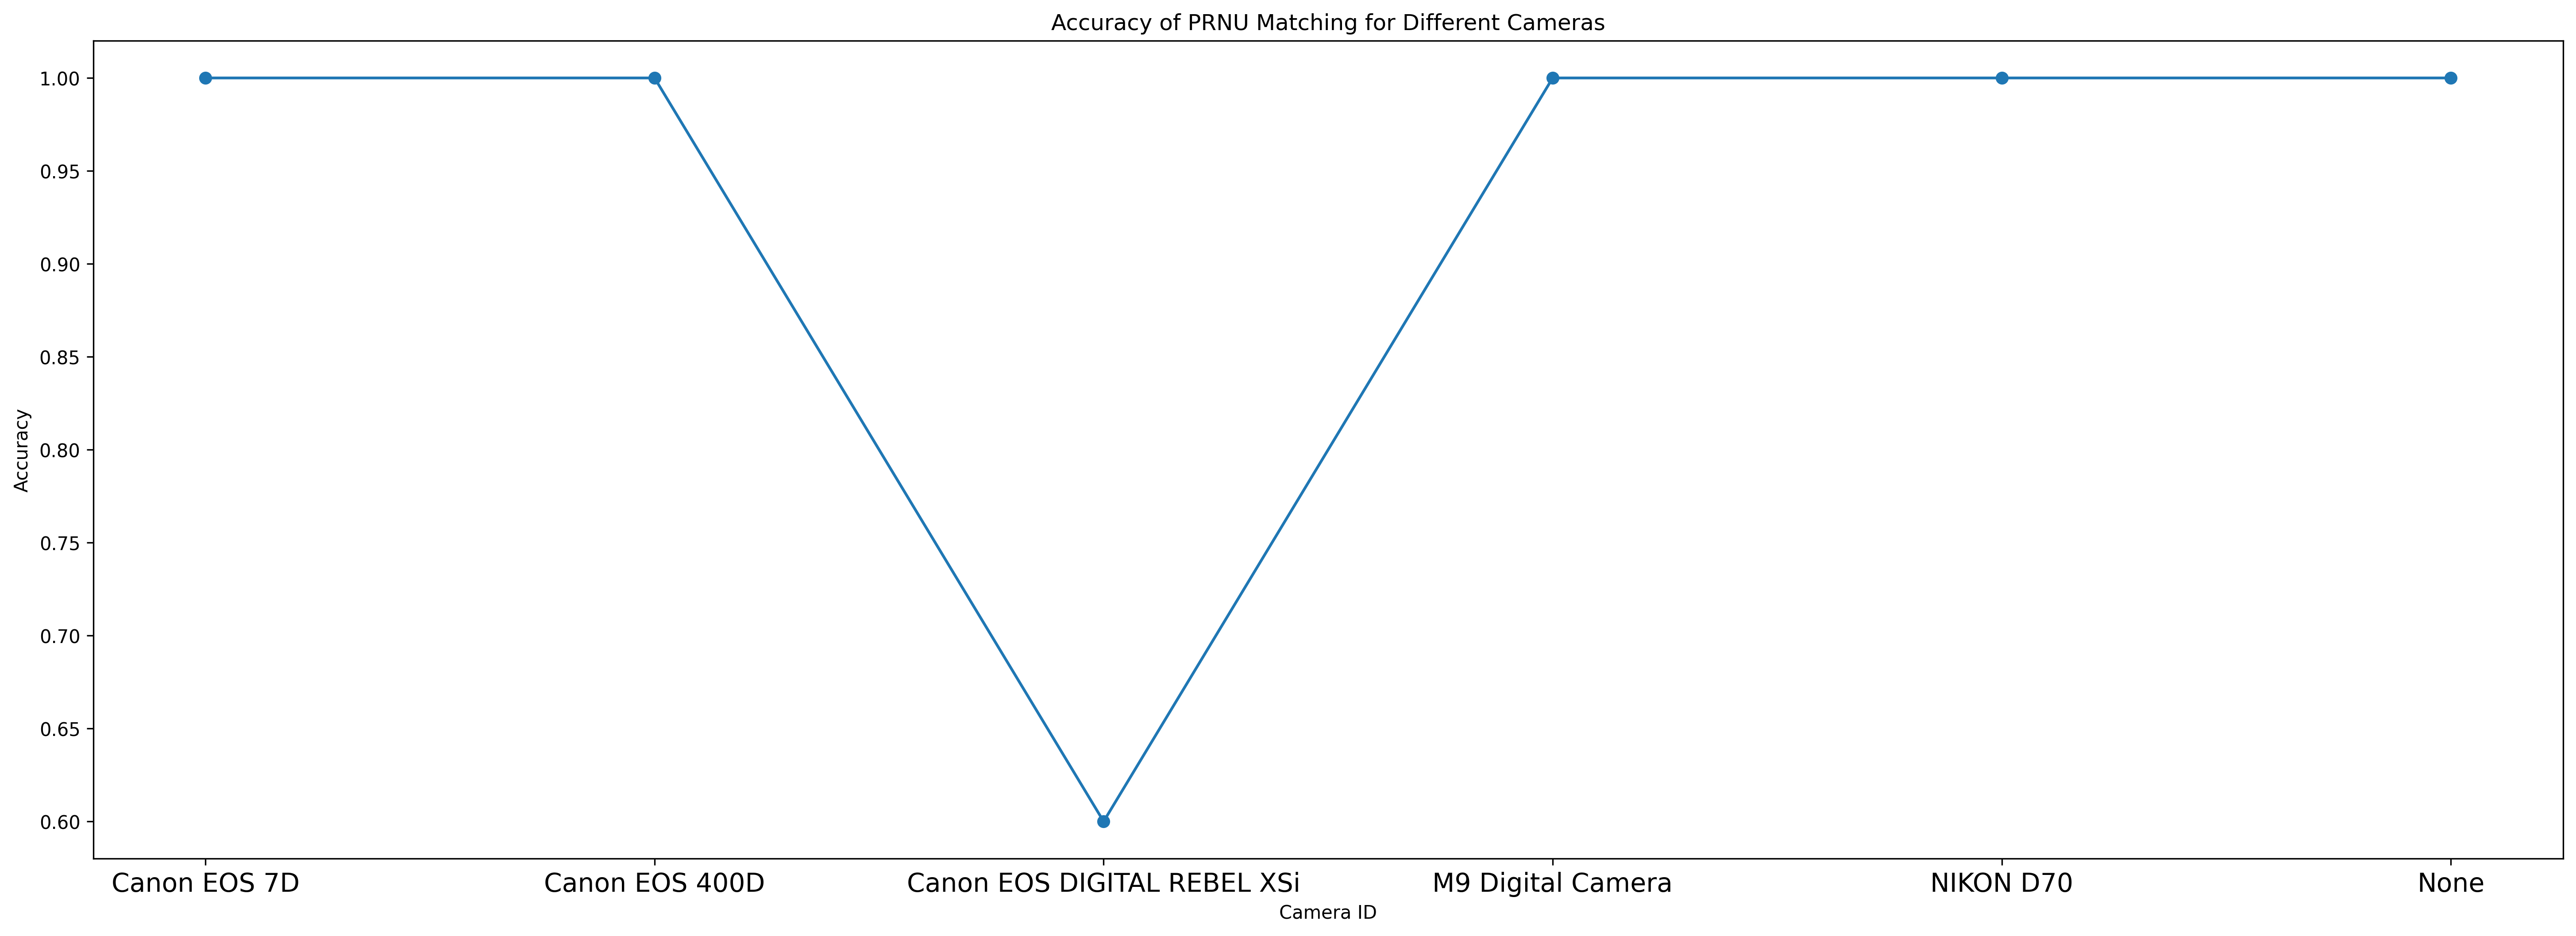

In [32]:
def correlate_prnu(test_image, prnu_fingerprint, target_size=(2048, 2048)):
    preprocessed_img = preprocess_image(test_image, target_size)
    denoised_img = wavelet_denoise(preprocessed_img)
    noise_residual = calculate_noise_residual(preprocessed_img, denoised_img)
    normalized_noise_residual = (noise_residual - np.mean(noise_residual)) / np.std(noise_residual)
    correlation, _ = pearsonr(normalized_noise_residual.flatten(), prnu_fingerprint.flatten())
    return correlation

def calculate_thresholds(prnu_library, train_images, target_size=(2048, 2048)):
    thresholds = {}
    max_images = 10  # Limit to at most 10 images per camera
    for camera_id, images in train_images.items():
        correlations = []
        images = images[:max_images]
        for img in tqdm(images, desc=f"Calculating threshold for {camera_id}"):
            correlation = correlate_prnu(img, prnu_library[camera_id], target_size)
            correlations.append(correlation)
        thresholds[camera_id] = min(correlations)*0.1
    return thresholds

def match_camera_with_threshold(test_image, prnu_library, thresholds, target_size=(2048, 2048)):
    matches = {}
    for camera_id, prnu_fingerprint in prnu_library.items():
        correlation = correlate_prnu(test_image, prnu_fingerprint, target_size)
        if correlation >= thresholds[camera_id]:
            matches[camera_id] = correlation / thresholds[camera_id]
    if matches:
        best_match = max(matches, key=matches.get)
        return best_match, matches[best_match]
    else:
        return "None", None

def evaluate_accuracy_with_threshold(prnu_library, test_images, thresholds, target_size=(2048, 2048)):
    correct_matches = 0
    total_tests = 0
    accuracy_results = {}
    for camera_id, images in test_images.items():
        correct = 0
        for img in tqdm(images, desc=f"Testing {camera_id}"):
            matched_camera, _ = match_camera_with_threshold(img, prnu_library, thresholds, target_size)
            total_tests += 1
            if matched_camera == camera_id:
                correct += 1
                correct_matches += 1
        accuracy = correct / len(images) if images else 0
        accuracy_results[camera_id] = accuracy
    overall_accuracy = correct_matches / total_tests if total_tests > 0 else 0
    return overall_accuracy, accuracy_results

def visualize_prnu(prnu_library):
    num_cameras = len(prnu_library)
    if num_cameras == 0:
        print("No cameras found in PRNU library.")
        return
    rows = 2
    cols = 3
    fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
    axs = axs.flatten()
    for idx, (camera_id, prnu_fingerprint) in enumerate(prnu_library.items()):
        ax = axs[idx]
        ax.imshow(prnu_fingerprint, cmap='gray')
        ax.set_title(camera_id)
        ax.axis('off')
    for ax in axs[len(prnu_library):]:
        fig.delaxes(ax)
    plt.tight_layout()
    plt.show()

def plot_accuracy(accuracy_results):
    cameras = list(accuracy_results.keys())
    accuracies = list(accuracy_results.values())
    plt.figure(dpi=300,figsize=(24,8))
    plt.plot(cameras, accuracies, marker='o')
    plt.xticks(fontsize=14)
    plt.xlabel("Camera ID")
    plt.ylabel("Accuracy")
    plt.title("Accuracy of PRNU Matching for Different Cameras")
    plt.show()

thresholds = calculate_thresholds(prnu_library, train_images, target_size)
print(f"Calculated correlation thresholds: {thresholds}")

overall_accuracy, accuracy_results = evaluate_accuracy_with_threshold(prnu_library, test_images, thresholds, target_size)
print(f"Overall accuracy on the test set: {overall_accuracy * 100:.2f}%")

visualize_prnu(prnu_library)
plot_accuracy(accuracy_results)


输出阈值

In [33]:
print(thresholds)

{'Canon EOS 7D': 0.016021234952207298, 'Canon EOS 400D': 0.006969683364794348, 'Canon EOS DIGITAL REBEL XSi': 0.006920206419938928, 'M9 Digital Camera': 0.005028384256867687, 'NIKON D70': 0.004904357139861901}
